### CS/ECE/ISyE 524 - Introduction to Optimization - Spring 2017

# Optimizing the WIMR Elevators

#### Bailey Flanigan (bgflanigan@wisc.edu), Andrew Duplissis (duplissis@wisc.edu)

### Table of Contents
1. [Introduction](#introduction)
2. [Mathematical Model](#mathmodel)
    1. [Discussion of ThyssenKrupp's ETD Algorithm](#2A)
    2. [Assumptions and Physical Elevator System Parameters](#2B)
    3. [Our Model](#2C)
3. [Solution](#solution)
    1. [Model Demonstration - Comparison to ThyssenKrupp ETD Algorithm](#3A)
    2. [Six-Elevator Simulation](#3B)
4. [Results and Discussion](#resultsdiscussion)
5. [Conclusion](#conclusion)
    1. [Full Model Formulation](#5A)
    2. [Energy and Wait Time Tradeoff](#5B)
6. [Appendix A - Usage Data Generation](#appendixA)
7. [Appendix B - Physical Parameters Data](#appendixB)

# 1. Introduction <a class="anchor" id="introduction"></a>
The Wisconsin Institute for Medical Research (WIMR) is a set of towers attached to UW Hospital that are chiefly dedicated to medical research. These two towers are each eight floors high and are serviced by a set of six elevators. The six WIMR elevators are "destination entry elevators", which means that, unlike typical elevators, the user does not interact with them by pushing up/down buttons outside each elevator and then selecting their floor inside each elevator. Rather, the WIMR elevators work as a unit, using a single keypad on each floor that allows users to enter their destination floor. 

As shown in the diagram below, to travel from their current floor to destination floor, a user approaches the cluster of elevators and selects their desired floor on a touchscreen keypad on the wall. The keypad then directs them to an elevator (labeled U, V, W, X, Y, Z). The user waits until that elevator arrives, boards it, and is taken to their floor (with potential stops along the way to pick up/drop of other patrons). The diagram below shows the flow of usage for a single user:

![Image Test](Figure_1.png)

The problem of calculating optimal elevator paths and assignments is a relatively well-studied problem, but it has been much more extensively studied for applications in non-destination entry elevators. We were not able to find research on a model that specifically optimizes elevator trajectory in destination entry elevators; however, we were able to learn a bit about the specific algorithm used by the WIMR elevators.

The algorithm used by the WIMR elevators to assign passengers to elevators is called Estimated Destination Time (ETD), and it was developed by ThyssenKrupp Elevator Inc. This algorithm is proprietary, but its basic functionality is outlined in a paper by its developers, titled *ETD Algorithm with Destination Dispatch and Booster Options* (Smith and Peters 2002). In essence, the algorithm accepts inputs of floor destinations on a person-by-person basis and then assigns that person to an elevator without incorporating any information from future destination entries. According to Smith *et al*, the ETD algorithm projects the total time-cost (TC) (defined as the wait time of the new user plus the additional cost to all previously-boarded users) of adding the new user to each possible elevator individually. It then assigns the new user to the elevator with the lowest computed TC. 

As we will discuss in the next section, after some investigation of the ETD algorithm's performance, we have determined that their algorithm for finding optimal hypothetical paths between floors is in some cases suboptimal. For this project, we are therefore interested in developing an algorithm that, for a single elevator, optimizes the path of the elevator-its "trajectory, as we will call it-to minimize the total wait time to all users. From this, elevator assignment logically follows. Throughout this paper, we will outline a mathematical model that finds the optimal trajectory for the minimization of wait time of all users with some simplifying assumptions. We will then illustrate the functionality of our model on a single elevator by comparing it to the performance of ThyssenKrupp's ETD algorithm on an example from their paper. Next, we will generalize our model by placing it within a 6-elevator, day-long simulation using usage data generated from probability distributions we defined (Appendix A). Using the results of this simulation, we will discuss the efficiency and optimality of our model. Finally, we will discuss improvements upon it that are yet to be made.

*Sources:*
*Smith, Roy. Peters, Richard. "ETD Algorithm With Destination Dispatch And Booster Options". Elevator World (2002): n. pag. Web. https://www.peters-research.com/index.php/support/articles-and-papers/42-etd-algorithm-with-destination-dispatch-and-booster-options*

# 2. Mathematical Model <a class="anchor" id="mathmodel"></a>
### A. Discussion of ThyssenKrupp's ETD Algorithm<a class="anchor" id="2A"></a>
While we had originally planned to base our model on the general structure of ThyssenKrupp's ETD algorithm, after further assessment of the performance of their algorithm based on an example provided in their paper, we concluded that its algorithm for calculting trajectories was not optimal. This lack of optimality was determined based on an example provided in Smith *et al* that demonstrates how the ETD algorithm performed when given a simple scenario. We outline this scenario below both to demonstrate that ThyssenKrupp's ETD algorithm is suboptimal, but also to familiarize the reader with the considerations of a model such as this using a simple example. 

*Note: In order to fully outline the problem they described, we had to make a few assumptions because their diagrams were relatively vague and not well-labeled; however, none of these assumptions were critical to our conclusion. Specifically, we deduced from the duration of trips that in their model, it takes 5 seconds to traverse a floor and 10 seconds to load/unload at a given stop. Current floors (unlabeled in the diagram) were deduced based on these numbers. These may not be exactly correct, but they are known to be close enough to demonstrate the following point with certainty.**

The example provided in the paper outlines the following scenario:

**A new user (user X) wishes to travel from floor 7 > 2.**

The three elevators in the system are in the following states:

| Elevator | Direction | Current Floor  | Current Task                | Computed TC of adding user X | 
| -------- |:---------:| --------------:| ---------------------------:|-----------------------------:|
| 1        | Up        | 4              | Deliver 1 person from 4 > 8 | 50s                          |
| 2        | Up        | 5              | Deliver 1 person from 5 > 6 | 55s                          |
| 3        | Down      | 6              | Deliver 8 people from 6 > 1 | 190s                         |

Based on these results, by the ThyssenKrupp implementation of ETD, user X would be added to Elevator 1, because this solution presents the lowest time cost. However, it can be shown that the computed TCs for each given elevator are not the optimal possible TCs--an issue which could have great influence over which elevator is selected. To illustrate this, let's consider the projected TC for Elevator 3.

**THYSSENKRUPP SOLUTION:**

Before adding user X, Elevator 3 has the following queue: $$6 \to 1$$
After adding user X, Elevator 3 has the following queue: $$ 6 \to 7 \to 2 \to 1$$
The TC is computed according to Equation 1, where:
$$TC = 25 + 5 + 8*(10 + 10) = 190$$
where it takes the elevator **5** seconds to reach user X from its current floor (6), the journey of the new user from 7 > 2 will take **25** seconds without additional stops for others, and the 8 people already in the elevator will each be delayed 20s for the dropoff and pickup of user X), incurring a cost of **8 x (10 + 10)** seconds.

**IMPROVED SOLUTION:**

Now consider instead that Elevator 3, given the same initial conditions, selected the following trajectory instead: 
$$ 6 \to 1 \to 7 \to 2$$
By the same calculation as before, we can show that the TC for this hypothetical trajectory is as follows:
$$TC = (25 + 30) + 25 = 80$$
where the new user waits **25** seconds for the elevator to travel from 6 > 1 and then **30** seconds to travel back up from 1 > 7. Finally, the journey of the new user from 7 > 2 will take **25** seconds without additional stops for others.

From this example, it can be clearly seen that by calculating a more optimal trajectory when computing TC, the projected total time cost to all users were the new user added to elevator 3 would have been much lower.
The implication of this discovery is that, while the ETD method is making an attempt to assign elevators in a manner that minimizes total wait time, their solution for optimizing *each individual elevator's trajectory* to minimize wait time is far from perfect. This conclusion is more broadly supported by the literature: for example, a paper that attempts to resolve a slightly different type of problem remarks that "Although [the Estimated Time to Destination] method is computationally efficient, the performance is not that good due to its greedy nature" (Sun, Zhao, and Luh 2010). Likely, when designing ETD, ThyssenKrupp made some heuristic approximations to increase computational speed and decrease product cost that in certain cases that compromised the optimality of their algorithm. 
 
In an attempt to improve upon the solution outcomes achieved by ThyssenKrupp's implementation of ETD, we will  solve the problem of computing the optimum trajectory *of a single elevator* using a Time-Dependent Traveling Salesman Problem (TDTSP) formulation. A TDTSP is a generalization of the Traveling Salesman Problem (TSP) that allows the cost of traveling from node i to node j (C[i,j]) to depend on the time t at which the trip from i to j occurs--thus, the cost of a possible trip is not C[i,j], but rather C[i,j,t]. As such, our problem can be classified as a Mixed-Integer Program (MIP). As we will demonstrate, even within this framework it is an exceptionally difficult problem to calculate the optimal elevator trajectory given the dependency of the cost C[i,j,t] on not only the time t, but the decisions made prior to time t. Throughout the remained of this section, we therefore present a model that solves a similar but simplified problem.

### B. Assumptions and Physical Elevator System Parameters <a class="anchor" id="2B"></a>
In the most general sense, it is important to first state that all six of the WIMR elevators (labeled U,V,W,X,Y,Z) can visit all eight floors in either tower, and none of the six elevators are otherwise subjected to specific constraints. Thus, all six elevators can be treated equally from an optimization perspective. It is also important to state that a user is assigned to an elevator immediately after they enter their destination (prior to any entry by any other user), so the elevator system cannot integrate the destinations of multiple users at once when assigning each user to an elevator. For simplicity, we assume that the system can accept at most one destination entry per second. Once a user is assigned to an elevator, their assignment cannot be changed. Additionally, the two most important physical parameters in the optimization of wait time are 1) the time it takes for the elevator to travel between floors, and 2) and the time it takes the elevator to load/unload passengers each time it makes a stop. By observation, we determined that on average, it takes an average of 2.36 seconds to travel between floors and an average of 6.7 seconds to make a stop to load/unload passengers. This dataset is included in full in Appendix B.

### C. Our Model - Dropoffs Only with Realistic Trip Time Implementation<a class="anchor" id="2C"></a>
As we will discuss further in our conclusion, it proved difficult to successfully implement and run a model that incorporated user's origins and destinations. Thus, the model presented below considers only users' destinations when computing the optimal trajectory and total cost of adding that user to a specific elevator. What this means in practice is that, when our model computes the hypothetical cost of adding a user to an elevator, it is assumed that the user will not need to be picked up but rather will instantaneously teleport to the inside of the elevator to which they are assigned. As normal, they will then be delivered to their destination by the elevator. Thus, in our system, the elevator never needs to modify its trajectory to pick people up, but rather just to drop them off. It also cannot account for the time a new user spends waiting for the elevator to arrive.

#### Model Foundations in TDTSP
As stated, we approach this problem using a version of the Time-Dependent Traveling Salesman Problem (TDTSP). A formulation of the general TDTSP model is outlined in a 1979 Operations Research paper by Fox, Gavish, and Graves (Fox, Gavis, and Graves, 1979). Our model bears many similarities to the model outlined in this paper.

First, just as Fox *et al* does in their formulation, our model includes a binary decision variable X, which stores which trips i > j are taken at time t. It is formally defined as follows:
$$X_{i,j,t}\,\,=\,binary\,variable\,representing\,whether\,the\,path\,from\,i\,\to\,j\,is\,taken\,at\,time\,t$$

It is important to note that i and j cannot take on all possible floors, but rather can take on only the values of the destination floors entered into the system. Similarly, time *t* does not represent time in seconds, but rather a count of the number of people who have been dropped off.

Constraints C1 - C4 in our model also correspond to the constraints outlined in this paper. As explained in the paper, C1 - C3 ensure that one state is visited at each time point and that all states are visited once; C4 ensures that no sub-tours exist in the final path. 
$$(C1)\,\,\,\,\,\,\,\sum_{j=1}^{n}\sum_{t = 1}^{n}X_{i,j,t}\,=\,1\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,i = 1,2,3,....,n$$

$$(C2)\,\,\,\,\,\,\,\sum_{i=1}^{n}\sum_{t = 1}^{n}X_{i,j,t}\,=\,1\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,j = 1,2,3,....,n$$

$$(C3)\,\,\,\,\,\,\,\sum_{i=1}^{n}\sum_{j = 1}^{n}X_{i,j,t}\,=\,1\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,t = 1,2,3,....,n$$

$$(C4)\,\,\,\,\,\,\,\sum_{j=1}^{n}\sum_{t = 2}^{n}tX_{i,j,t}-\sum_{j=1}^{n}\sum_{t = 1}^{n}tX_{j,i,t}\,=\,1\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,i = 1,2,3,....,n$$

Finally, our objective is also roughly consistent with the objective in this paper and seeks to minimize the cost incurred by all total trips:

$$Minimize\,\,\sum_{i=1}^{n}\sum_{d=1}^{n}\sum_{t = 1}^{n}C_{d,t}*X_{i,d,t}$$

#### Building on the TDTSP to Incorporate Previous Path-Dependence
While our model bears similarity to a general TDTSP, our problem is more complex because not only does the cost of the trip from i > j depend on the time t at which it occurs; it also depends on which trips were taken previously in the resulting trajectory. Our model therefore first diverges from the general TDTSP in the sense that, while in Fox *et al*, the cost matrix *C* can be treated as a constant parameter, our cost matrix *C* must be modeled as a decision variable: 
$$C_{d,t}\,\,=\,the\,cost\,of\,transporting\,the\,number\,of\,people\,who\,must\,go\,to\,floor\,d\,if\,they\,arrive\,at\,time\,t$$

As you can see from its dimensions *d*, *t*, C does not account for the cost of i > j, but rather just the cost to travel to destination *d*; this is because the model is not aware of people's origins, so people are classified only based on their destinations. Before we can constrain *C*  according to to its definition, we must first define the two parameters required by our model, *P* and *D*, as well as a new decision variable, *U*. 

In order to compute the cost *C* of delivering the users with destination *d* to their destination, the model must have two pieces of data: the distance *D* between any two floors *i,j*, and the number of people *P* with destination *d*. This information is captured in the following parameters, which must be computed before running the model:
$$D_{i,j}\,\,=\,distance\,traveled\,on\,the\,trip\,i \to j$$
$$P_{d}\,\,=\,number\,of\,people\,with\,destination\,d$$

When computing the cost at time *t*, we then run into the issue that the total cost of traveling *i > j* at time *t* depends on how many users are in the elevator, which in turn depends on how many users have been dropped off, which in turn depends on which trips were previously taken. This is a complexity that is not accounted for in the general TDTSP, so to account for the fact that the group of users with destination *d* may or may not be present at time *t* and therefore may or may not contribute to the cost of the trip *i > j* taken at time *t*, we introduce an additional binary variable *U*, which represents whether or not this is the case:

$$U_{i,j,t,d}\,\,=\,binary\,variable\,representing\,whether\,the\,group\,with\,destination\,d\,is\,present\,on\,the\,trip\,from\,i \to j\,at\,time\,t$$

With these items defined, we can now constrain the entries of cost matrix *C* as follows:

$$(C5)\,\,\,\,\,\,\,C_{d,t} = P_{d}*6.7*(t-1) + P_{d}*2.36*\sum_{i=1}^{n}\sum_{j=1}^{n}\sum_{k=1}^tD_{i,j}*U_{i,j,k,d}\,\,\,\,\,\,\,d,t = 1,2,3,...,n$$

If we break this constraint down into its two added terms, we can see that the first term calculates the time cost of all intermediate stops to all users with destination *d* if they are delivered at time *t*, which in this model does not represent a literal time but instead a stop number. For example, if 2 users traveling to their destination *d* are dropped off at stop number 3 in the trajectory, the first term would be equal to 2 x 6.7 x 2. 1 is subtracted from *t* because we don't want to count their own disembarking in the cost, since the user disembarking is not waiting, but rather exiting the elevator.  

The second term is more complex, and represents the cost to all users with destination *d* incurred as the elevator traverses other floors before dropping them off. In words, it represents (number people going to destination *d*) x (time to traverse one floor = 2.36) x (the sum of the distance traveled over all trips taken by users with destination *d*).

Finally, the newly-defined binary matrix *U* must be appropriately constrained according to its definition. This requires three constraints:

$$(C6)\,\,\,\,\,\,\,\sum_{k=1}^{t}\sum_{i=1}^{n}\sum_{j=1}^{n}U_{i,j,k,d}\geq\sum_{i=1}^{n}tX_{i,d,t}\,\,\,\,\,\,\,d,t = 1,2,3,...,n$$

$$(C7)\,\,\,\,\,\,\,\sum_{d=1}^{n}\sum_{i=1}^{n}\sum_{j=1}^{n}U_{i,j,t,d} = n - t + 1\,\,\,\,\,\,\,t = 1,2,3,...n$$

$$(C8)\,\,\,\,\,\,\,U_{i,j,t,d} \leq X_{i,j,t}\,\,\,\,\,\,d,t,i,j = 1,2,3,...n$$

Perhaps the easiest of these to understand is C8, which simply requires that for *U* to state that a path *i > j* to be taken by users of destination *d* at time *t*, this path must also be taken in the overall solution (represented by *X*). 

C6 requires that for any time *t* and destination *d*, the total trips taken (from any *i > j*) by people with destination *d* by time *t* must be at least as many as the time of arrival at destination d. In simpler terms, this means that users with destination *d* must take at least as many trips as is required to reach destination *d*. Note that, unless the system reaches *d* at time *t*, the left-hand term will be 0. In order to minimize the cost, the lefthand side will be as small as possible at any given time, and will be optimally set to equal (rather than be greater than) the time at which the system arrives at destination *d*.

To understand C7, recall that *t* does not represent literal time, but rather a count of how many people have been dropped off (the stop number, essentially). C7 enforces the fact that, for any time t, the number of groups with different destinations occupying the elevator for the trip taken at time *t* (for any trip *i > j*) must be equal to the number of groups with different destinations left on the elevator, which equals n - t - 1, where n = the original number of destinations and t-1 = the number of dropoffs so far.

#### Full Model - Standard Form

$$Minimize\,\,\,\,\,\,\sum_{i=1}^{n}\sum_{d=1}^{n}\sum_{t = 1}^{n}C_{d,t}*X_{i,d,t}$$

$$Subject\,to \,\,\,\,\,\,\,\,\sum_{j=1}^{n}\sum_{t = 1}^{n}X_{i,j,t}\,=\,1\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,i = 1,2,3,....,n\,\,\,\,\,\,\,(C1)$$

$$\sum_{i=1}^{n}\sum_{t = 1}^{n}X_{i,j,t}\,=\,1\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,j = 1,2,3,....,n\,\,\,\,\,\,\,(C2)$$

$$\sum_{i=1}^{n}\sum_{j = 1}^{n}X_{i,j,t}\,=\,1\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,t = 1,2,3,....,n\,\,\,\,\,\,\,(C3)$$

$$\sum_{j=1}^{n}\sum_{t = 2}^{n}tX_{i,j,t}-\sum_{j=1}^{n}\sum_{t = 1}^{n}tX_{j,i,t}\,=\,1\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,i = 1,2,3,....,n\,\,\,\,\,\,\,(C4)$$

$$C_{d,t} = P_{d}*6.7*(t-1) + P_{d}*2.36*\sum_{i=1}^{n}\sum_{j=1}^{n}\sum_{k=1}^tD_{i,j}*U_{i,j,k,d}\,\,\,\,\,\,\,d,t = 1,2,3,...,n \,\,\,\,\,\,\,(C5)$$

$$\sum_{k=1}^{t}\sum_{i=1}^{n}\sum_{j=1}^{n}U_{i,j,k,d}\geq\sum_{i=1}^{n}tX_{i,d,t}\,\,\,\,\,\,\,d,t = 1,2,3,...,n\,\,\,\,\,\,\,(C6)$$

$$\sum_{d=1}^{n}\sum_{i=1}^{n}\sum_{j=1}^{n}U_{i,j,t,d} = n - t + 1\,\,\,\,\,\,\,t = 1,2,3,...n\,\,\,\,\,\,\,(C7)$$

$$U_{i,j,t,d} \leq X_{i,j,t}\,\,\,\,\,\,d,t,i,j = 1,2,3,...n\,\,\,\,\,\,\,(C8)$$

*Sources:*

*Smith, Roy. Peters, Richard. "ETD Algorithm With Destination Dispatch And Booster Options". Elevator World (2002): n. pag. Web. https://www.peters-research.com/index.php/support/articles-and-papers/42-etd-algorithm-with-destination-dispatch-and-booster-options*

*Jin Sun, Qian-Chuan Zhao, and Peter B Luh. "Optimization Of Group Elevator Scheduling With Advance Information". IEEE Transactions on Automation Science and Engineering 7.2 (2010): 352-363. Web. https://pdfs.semanticscholar.org/89e2/9cb7363d1c00e2149dd7a1ff94a37251b2d7.pdf*


*Kenneth R. Fox, Bezalel Gavish, Stephen C. Graves, (1980) Technical Note—An n-Constraint Formulation of the (Time-Dependent) Traveling Salesman Problem. Operations Research 28(4):1018-1021. http://dx.doi.org/10.1287/opre.28.4.1018*

# 3. Solution<a class="anchor" id="solution"></a>

### A. Model Demonstration - Comparison to ThyssenKrupp ETD Algorithm<a class="anchor" id="3A"></a>
As in the introduction, we will use the Elevator 3 scenario provided in the Smith *et al* paper to give insight into the functionality of our optimization algorithm and show that, in this example, it produces a more optimal outcome than that provided by the model described in Smith *et al*. The complicating factor in using this example is that it includes an added user with an origin (7) and a destination (2), while our model incorporates only destinations. To make a valid comparison, we must formulate a comparable problem using the fact that, in any valid solution to the problem of optimally ordering the trajectory of Elevator 3, the elevator's path must satisfy the following criteria:

(1) It must, in some order, visit floors 6, 1, 7, and 2

(2) It must start at floor 6, its current floor

(3) Floor 7 must be visited before floor 2. 

Based on these constraints, let's reformulate the problem to retain these constraints but also provide a valid test of our model. In this version of the problem, we define Elevator 3 to be currently at floor 6 and contain 10 people with destinations distributed in the following way:

(1) Deliver 8 people to floor 1

(2) Deliver 1 person to floor 7

(3) Deliver 1 person to floor 2

If, in addition, we place a special constraint on our model to force it to provide a solution in which the person going to 7 is dropped off before the person at 2, this problem is essentially comparable to the original problem. The main difference is that, in the original problem, one person was waiting outside the elevator until it arrived at 7 and then one person (the same person) waited inside the elevator until it arrived at 2; in the reformulated problem, *two* people are waiting inside the elevator until the floor reaches 7 and one person is waiting inside the elevator until it reaches 2. Giving the ETD algorithm the benefit of the doubt, the difference between these problems only makes more costly the time taken to reach floor 7, so this new problem should actually *reinforce* the decision made by their algorithm to select the trajectory 6 > 7 > 2 > 1 (the trajectory selected by their algorithm in the original example). Because of this, we can assume that at its very best performance, given this problem ThyssenKrupp's ETD algorithm will elect the same trajectory, 6 > 7 > 2 > 1, to distribute the 10 people in the elevator to their respective floors.

Now that we have justified this comparison, we can compute and compare the total time costs incurred using the trajectory determined by their algorithm and by our algorithm. When interpreting the numerical answers in this section, it is important to note that, when working with this scenario in our introduction, we computed Total Time Cost (TC). Now, we are comparing Total Wait Time, which is analgous but different than TC in the sense that TC computes the *added* wait time incurred by adding the new user; TW represents the total wait time overall (not just the extra cost incurred). Furthermore, we use different time duration parameters to compute these values, because these are the time duration parameters that are true to the WIMR elevators and allow us to draw conclusions about how our model performs in comparison to ETD in the context of the WIMR elevators.

**ThyssenKrupp ETD Algorithm:**
$$6 \to 7 \to 2 \to 1 : WT = 276 s$$
$$WT = 10*2.36*1 + 10*6.7 + 9*2.36*5 + 9*6.7 + 8*2.36*1 = 276$$

**Our Algorithm:**
$$6 \to 1 \to 7 \to 2 : WT = 178 s$$
$$(see\,results\,below)$$

In [1]:
# Estimated run time: 1 minute

states = [6,1,2,7]         # states that need to be visited (first state must be current floor)
P = [0,8,1,1]              # numbers of people needing to go to floors corresponding to those in destinations
numstates = length(states) # counts numbers of states


# Compute distance matrix as described in mathematical model
############################################################
D = zeros(numstates,numstates)
for j = 1:numstates
    for i = 1:numstates
        D[i,j] = abs(states[i] - states[j])
    end
end  


# Set up model according to mathematical model
############################################################
using JuMP, Gurobi

m = Model(solver = GurobiSolver(OutputFlag = 0))

# Decision Variables
@variable(m,x[1:numstates,1:numstates,1:numstates],Bin)
@variable(m,C[1:numstates,1:numstates])
@variable(m,u[1:numstates,1:numstates,1:numstates,1:numstates],Bin) 

# Constraints C1 - C3
for k = 1:numstates
    @constraint(m,sum(x[k,j,t] for j = 1:numstates,t = 1:numstates) == 1)
    @constraint(m,sum(x[i,k,t] for i = 1:numstates,t = 1:numstates) == 1)
    @constraint(m,sum(x[i,j,k] for i = 1:numstates,j = 1:numstates) == 1)
end
                                    
# Constraint C4                                                                        
for i = 2:numstates
   @constraint(m,sum(x[i,j,t]*t for j = 1:numstates,t = 2:numstates) - sum(x[j,i,t]*t for j = 1:numstates,t = 1:numstates) == 1)
end   

# Constraints C5 - C6
for d = 1:numstates
    for t = 1:numstates
        @constraint(m,C[d,t] == P[d]*(t-1)*6.7 + P[d]*2.36*sum(u[i,j,k,d]*D[i,j] for i = 1:numstates,j = 1:numstates,k = 1:t))
        @constraint(m,sum(u[i,j,k,d] for k = 1:t,i = 1:numstates,j = 1:numstates) >= sum(x[a,d,t] for a = 1:numstates)*t)
    end
end  
                                                                                        
# Constraint C7
for t = 1:numstates
    @constraint(m,sum(u[i,j,t,d] for d = 1:numstates, i = 1:numstates, j = 1:numstates) == numstates - t + 1)
end
       
# Constraint C8
for d = 1:numstates
    for t = 1:numstates
        for i = 1:numstates
            for j = 1:numstates
                @constraint(m,u[i,j,t,d] <= x[i,j,t])
            end
        end
    end
end
                                                                                                    
# Additional constraint to (non-explicitly) force 7 to be visited before 2 for this particular case                                                     
@constraint(m,x[3,4,3] == 0)
                                                                                                                                                                                                                                                                                                          
@objective(m, Min, sum(x[i,d,t]*C[d,t] for i = 1:numstates, d = 1:numstates, t = 1:numstates)) 
                                                                                            
solve(m)

# Display Results
############################################################
solution = getvalue(x)
opt_queue = zeros(numstates)
for t = 1:numstates
    for i = 1:numstates
        for j = 1:numstates
            if solution[i,j,t] > .5
                opt_queue[t] = states[i]                                                                                                                
                continue
            end
        end
    end
end
                                                                                                                
## Warning: this print statement is hard-coded
println("The optimal elevator trajectory is ",opt_queue[1]," > ",opt_queue[2]," > ",opt_queue[3]," > ",opt_queue[4])
println()                                                                                                            
println("The total time cost to all patrons is ",getobjectivevalue(m)," seconds")
                                                                                                                                                                                    
u = getvalue(u)
for d = 2:numstates
    println()                                                                                                                
    println("People with Destination ",states[d],":")
    for t = 1:numstates
        for i = 1:numstates
            for j = 1:numstates
                if u[i,j,t,d] > 0.5
                    println(" travel from ",states[i]," to ",states[j]," at time ",t)
                end
            end
        end
    end
end


The optimal elevator trajectory is 6.0 > 1.0 > 7.0 > 2.0

The total time cost to all patrons is 178.22000000000006 seconds

People with Destination 1:
 travel from 6 to 1 at time 1

People with Destination 2:
 travel from 6 to 1 at time 1
 travel from 1 to 7 at time 2
 travel from 7 to 2 at time 3

People with Destination 7:
 travel from 6 to 1 at time 1
 travel from 1 to 7 at time 2


Above, you can see that the resulting optimal trajectory to solve the scenario outlined above is 6 > 1 > 7 > 2. To give some transparency about what our model is actually doing, we provide an additional printout that gives insight into the entires of matrix U, the main workhorse of our model. By reading out values from our U matrix, you can see that our model has determined that those with Destination 1 took the trip 6 > 1 at time 1 and then took no subsequent trips. This makes sense, because according to the optimal trajectory, floor 1 is the first stop. Similar logic can be used to understand the printouts for other destination groups in the context of the optimal trajectory.

### B. Six - Elevator Simulation of Model<a class="anchor" id="3B"></a>
While the above comparison is interesting and gives insight into how our model is working, it provides no information on how it would perform in the context of a multi-elevator system. We therefore now generalize our model to the WIMR elevator system by placing our model within a simulation that includes 6 elevators. We will run the simulation on an entire day's worth of data to gain insight into how it would perform at WIMR on a weekday. To integrate multiple elevators, we simply calculate the total wait time associated with adding the new person to each elevator individually, compare the added cost, and then assign the new person to the new elevator with the smallest added cost.

Because we could not access actual data on the usage of the WIMR elevators, we have used our own collective observations (we have both worked at WIMR for multiple years) to generate dummy data on elevator usage for a 24-hr timespan. The process by which we generated this data is probabilistic and is detailed in Appendix A. For now, it suffices to say that this dataset includes data for each second of a 24-hour day. At each second, there is a recorded origin and destination floor. If, in a particular second, origin and destination are recorded as zeros, this indicates that no one entered a destination at that timepoint. 

In order to simplify the simulation, we scaled the time between floors down by a factor of 2.36 so that it would be 2.36/2.36 = 1. We similarly scaled the loading time 6.7s down by the same factor to 6.7/2.36 = 2.83, which we approximated as 3. We scaled and then made this approximation to avoid the elevators being between discrete floors when we were attempting to run the model. This scaling should not influence the choices that the algorithm makes, because the algorithm's choice is based on the ratio of inter-floor time (2.36) to wait-at-floor time (6.7), so scaling these (approximately) equally should have little effect on the selected trajectories. Before plotting the data, we will scale the wait times back up by 2.36s so that they are representative of more realistic wait times. 

In [2]:
# Estimated run time: 10 minutes

using JuMP, Gurobi

# Set up Elevator Type with attributes
############################################################
type Elevator
    name              # elevator number
    status            # 1 = waiting for person to board/disembark, 2 = in motion
    wait_time         # amount of time waiting so far for boarding
    queue             # current queue
    people            # people who want to go to each floor in queue
    queue_length      # current number of floors in queue
    num_people        # current number of people in elevator
    currfloor         # current floor
    objective         # stores previous objective to compare with new objective
    temp_objective    # hypothetical new objective with additional person
    temp_queue        # hypothetical new queue list with additional person
    temp_people       # hypothetical new people list with additional person
    wait_data         # tracks wait time data over time
    floor_data        # tracks floor at over time
end


# Method: construct_inputs
# Constructs inputs to model given current data of passed elevator object
# Model takes Q matrix, P matrix in specific format:
#  - Q matrix is the floors to be visited. Must not contain duplicates,
#    first entry must be current floor, constains destination of new user
#  - P matrix is the corresponding people matrix, and provides the number
#    of people going to each floor ordered corresponding to Q
##########################################################################

function construct_inputs(elevator,newdest)
    # if the elevator is not at a destination, construct Q so its first entry is the
    # elevator's current floor, and the rest of it is the current queue of the elevator.
    # Construct P correspondingly, where 0 people have destination = current floor.
    if elevator.currfloor != elevator.queue[1]   
        L = elevator.queue_length + 1
        Q = zeros(L)
        P = zeros(L)
        Q[2:end] = elevator.queue[1:L-1]
        P[2:end] = elevator.people[1:L-1]
        Q[1] = elevator.currfloor
        P[1] = 0
        
    # repeat the previous step except if the elevator is at a destination, ignore the first 
    # entry of the elevator's current queue because otherwise that entry will be duplicated 
    # when currfloor is added at the first index 
    else
        L = elevator.queue_length
        Q = zeros(L)
        P = zeros(L)
        Q[2:L] = elevator.queue[2:L]
        P[2:L] = elevator.people[2:L]
        Q[1] = elevator.currfloor
        P[1] = 0
    end
    
    # check if destination is already in Q, and if it is, store its index
    ind_dest = findfirst(Q,newdest)
    
    # if not found, append the destination to Q and add that 1 person wants to go there to P
    if ind_dest == 0
        append!(Q,newdest)
        append!(P,1)
        
    # if found, increment the number of people going to that destination using known index
    elseif ind_dest > 1
        P[ind_dest] = P[ind_dest] + 1
    end
    
    # return Q and P as specified in the method definition
    return Q,P
end 


# Method: dropoff
# Is called by update_elevators() and executes all updates specific to
# elevator object when the elevator is stopping to drop someone off. This 
# method accounts for special cases due to instances in which the elevator
# dropping someone off has just been selected as the optimal elevator,
# a case which affects how its queue is updated.
##########################################################################

function dropoff(elevator,if_opt)
    # update elevator to enter waiting status, because each time it makes a dropoff it must
    # hold at that floor for 3 seconds while users disembark
    elevator.status = 1
    elevator.wait_time = 1
    
    # If the elevator being updated was not selected as the optimal elevator, remove the first
    # entry of the elevator's current queue, as that destination has now been reached 
    if if_opt == false
        elevator.queue[1:elevator.queue_length] = elevator.queue[2:elevator.queue_length+1]
        elevator.people[1:elevator.queue_length] = elevator.people[2:elevator.queue_length+1]     
    end
    
    # the returned queue of the optimization model automatically removes the first floor in the queue,
    # so we do not need to do it.
    # we do need to, however, update the objective to account for the time the elevator must spend
    # waiting on its current floor for dropoff before beginning motion again.
    if if_opt == true
        elevator.objective = elevator.objective + (3 - elevator.wait_time)*elevator.num_people  
    end
    
    # update the number of people in the elevator and the number of entries in its queue
    elevator.num_people = sum(elevator.people)
    elevator.queue_length = findfirst(elevator.queue,0) - 1
     
end    


# Method: update_elevators
# Updates elevator parameters for passed elevator object. Accounts for special
# cases required when elevator being updated is optimal (further explanation below).
########################################################################## 

function update_elevators(opt_enum)
    enum = 1
    for elevator in elevators
    
        # If the elevator being updated was just selected as the optimal elevator
        if enum == opt_enum

            elevator.objective = elevator.temp_objective       
            
            # if elevator is waiting at a dropoff:
            # - update its queue with the new optimal queue
            # - update its people with the corresponding people
            # - update its number of people
            # - update the number of entries in its queue
            # - account for wait time due to waiting at current floor in its objective
            if elevator.status == 1 && elevator.wait_time < 3
                elevator.queue = elevator.temp_queue
                elevator.people = elevator.temp_people
                elevator.num_people = sum(elevator.people)
                elevator.queue_length = findfirst(elevator.queue,0) - 1
                elevator.wait_time = elevator.wait_time + 1
                elevator.objective = elevator.objective + (3 - elevator.wait_time)*elevator.num_people 
            
            # if elevator is in motion or has been waiting but is now done waiting
            elseif elevator.status == 2 || (elevator.status == 1 && elevator.wait_time == 3) 
                elevator.wait_time = 0 
                elevator.status = 2
                
                # if the elevator has reached a destination floor
                # - update queue and people arrays with new optimal values
                # - call dropoff method to make all necessary updates for dropoff
                if elevator.queue[1] == elevator.currfloor
                    elevator.queue = elevator.temp_queue
                    elevator.people = elevator.temp_people 
                    dropoff(elevator,true)   
                
                # if the elevator has not reached its destination floor
                # - update queue and people arrays with new optimal values
                # - increment the floor in the direction toward next destination
                else
                    elevator.queue = elevator.temp_queue
                    elevator.people = elevator.temp_people 
                    if elevator.queue[1] > elevator.currfloor       
                        elevator.currfloor = elevator.currfloor + 1  # move up one floor 
                    elseif elevator.queue[1] < elevator.currfloor && elevator.queue[1] > 0   
                        elevator.currfloor = elevator.currfloor - 1
                    end
                end
                
                # update the number of people and queue length parameters
                elevator.num_people = sum(elevator.people)
                elevator.queue_length = findfirst(elevator.queue,0) - 1
            end
        
        # If the elevator being updated was not just selected as the optimal elevator
        else
            # if elevator is waiting
            if elevator.status == 1 && elevator.wait_time < 3
                elevator.wait_time = elevator.wait_time + 1         
        
            # if the elevator is in motion or is waiting but just finished waiting
            elseif elevator.status == 2 || (elevator.status == 1 && elevator.wait_time == 3)
                    elevator.wait_time = 0
                    elevator.status = 2
                if elevator.queue[1] != 0
                    if elevator.queue[1] > elevator.currfloor        # if the next destination is greater than the current floor
                        elevator.currfloor = elevator.currfloor + 1  # move up one floor 
                    elseif elevator.queue[1] < elevator.currfloor    # if the next destination is smaller than the current floor
                        elevator.currfloor = elevator.currfloor - 1  # move down one floor
                    elseif elevator.currfloor == elevator.queue[1]   # if the elevator has just arrived at a destination
                        dropoff(elevator,false)
                    end
                end
            end
            elevator.num_people = sum(elevator.people)
            elevator.queue_length = findfirst(elevator.queue,0) - 1
            elevator.objective = elevator.objective - elevator.num_people 
        end
        
        # this cleans up any off-by-one errors (according to testing, not necessary, but implemented in case test cases were missed)
        if elevator.queue[1] == 0
            elevator.objective = 0
        end
        
        # reset all temp values of elevator to 0 
        elevator.temp_objective = 0
        elevator.temp_queue = zeros(10)
        elevator.temp_people = zeros(10) 
        
        # increment elevator number tracker    
        enum = enum + 1
    end
end


# Method: display_elevator
# This is for testing purposes only, and is not called in the model.
# Displays the attributes of the passed elevator object when called.
# Note that the displayed floor is one unit ahead of the rest of the data
# in the printout because floor updates at the end in of the loop in
# preparation for the next loop
########################################################################## 

function display_elevator(elevator::Elevator,temps::Bool)
    println("The attributes for elevator ",elevator.name," are:")
    println("status: ",elevator.status)
    println("wait time: ",elevator.wait_time)
    println("queue: ",elevator.queue)
    println("people: ", elevator.people)
    println("queue length: ",elevator.queue_length)
    println("number of people: ",elevator.num_people)
    println("curr floor: ",elevator.currfloor)
    println("objective: ",elevator.objective)
    if temps == true
        println("temp objective: ",elevator.temp_objective)
        println("temp queue: ",elevator.temp_queue)
        println("temp people: ",elevator.temp_people)
    end
    println()
end


# Model Execution:
# For every time t in T = 1:86,400 seconds in a day, model pulls a randomized
# destination from the dummy data. If it contains a non-zero entry (ie a user
# came to the elevator in that second), the simulation calculates the optimal
# trajectory for each elevator in the hypothetical case that the new user
# was added. The simulation then selects the elevator that minimizes total
# incurred wait time to all users and assigns the new user to that elevator.
########################################################################## 

raw = readcsv("dummydata.csv")
orig = raw[:,1];    # origins data
dest = raw[:,2];    # destinations data
T = size(orig)[1]   # number of time points = 86,400
CAPAC = 10          # elevator capacity

e1 = Elevator(1,2,0,zeros(CAPAC),zeros(CAPAC),0,0,1,0,0,zeros(CAPAC),zeros(CAPAC),zeros(2,T),zeros(1,T))
e2 = Elevator(2,2,0,zeros(CAPAC),zeros(CAPAC),0,0,1,0,0,zeros(CAPAC),zeros(CAPAC),zeros(2,T),zeros(1,T))
e3 = Elevator(3,2,0,zeros(CAPAC),zeros(CAPAC),0,0,1,0,0,zeros(CAPAC),zeros(CAPAC),zeros(2,T),zeros(1,T))
e4 = Elevator(4,2,0,zeros(CAPAC),zeros(CAPAC),0,0,1,0,0,zeros(CAPAC),zeros(CAPAC),zeros(2,T),zeros(1,T))
e5 = Elevator(5,2,0,zeros(CAPAC),zeros(CAPAC),0,0,1,0,0,zeros(CAPAC),zeros(CAPAC),zeros(2,T),zeros(1,T))
e6 = Elevator(6,2,0,zeros(CAPAC),zeros(CAPAC),0,0,1,0,0,zeros(CAPAC),zeros(CAPAC),zeros(2,T),zeros(1,T))

elevators = [e1,e2,e3,e4,e5,e6]
 
# For every second of a day:
# 1) Check to see if a patron has arrived at the elevator
# 2) If so, calculate the total wait time associated with adding them to each of the 6 elevators
# 3) Compare wait times for each elevator and select the elevator with the lowest projected time cost
# 4) place the user in the optimal elevator and update all elevators
###############################################################################
for time = 1:T
    
    # create variable to store number of optimal elevator
    opt_enum = 0
    
    # check if someone is at the elevator
    if orig[time] != 0
        
        newdest = dest[time]
        enum = 1
        
        # for each elevator, compute the projected wait time of all users combined
        # were the new user with destination newdest to be added to each elevator.
        for elevator in elevators
            
            if (elevator.num_people >= CAPAC)
                println("elevator ",enum," is at capacity.")
                continue
            end
            
            # construct parameters
            Q,P = construct_inputs(elevator,newdest)
            numstates = length(Q)

            D = zeros(numstates,numstates)
            for j = 1:numstates
                for i = 1:numstates
                    D[i,j] = abs(Q[i] - Q[j])
                end
            end  
            
            # run optimization
            using JuMP, Gurobi

            m = Model(solver = GurobiSolver(OutputFlag = 0))
            @variable(m,x[1:numstates,1:numstates,1:numstates],Bin) # define binary variables that check if you travel from floor i to floor j at time t
            @variable(m,C[1:numstates,1:numstates])
            @variable(m,u[1:numstates,1:numstates,1:numstates,1:numstates],Bin)

            # CONSTRAINT C1 - C3
            for k = 1:numstates
                @constraint(m,sum(x[k,j,t] for j = 1:numstates,t = 1:numstates) == 1)
                @constraint(m,sum(x[i,k,t] for i = 1:numstates,t = 1:numstates) == 1)
                @constraint(m,sum(x[i,j,k] for i = 1:numstates,j = 1:numstates) == 1)
            end

            # CONSTRAINT C4                                                                        
            for i = 2:numstates
               @constraint(m,sum(x[i,j,t]*t for j = 1:numstates,t = 2:numstates) - sum(x[j,i,t]*t for j = 1:numstates,t = 1:numstates) == 1)
            end   

            # CONSTRAINT C5 - C6
            for d = 1:numstates
                for t = 1:numstates
                    @constraint(m,C[d,t] == P[d]*(t-1)*3 + P[d]*1*sum(u[i,j,k,d]*D[i,j] for i = 1:numstates,j = 1:numstates,k = 1:t))
                    @constraint(m,sum(u[i,j,k,d] for k = 1:t,i = 1:numstates,j = 1:numstates) >= sum(x[a,d,t] for a = 1:numstates)*t)
                end
            end  

            # CONSTRAINT C7
            for t = 1:numstates
                @constraint(m,sum(u[i,j,t,d] for d = 1:numstates, i = 1:numstates, j = 1:numstates) == numstates - t + 1)
            end

            # CONSTRAINT C8
            for d = 1:numstates
                for t = 1:numstates
                    for i = 1:numstates
                        for j = 1:numstates
                            @constraint(m,u[i,j,t,d] <= x[i,j,t])
                        end
                    end
                end
            end

            @objective(m, Min, sum(x[i,d,t]*C[d,t] for i = 1:numstates, d = 1:numstates, t = 1:numstates))

            solve(m)

            # construct and return data on optimal Q matrix, P matrix, and objective
            objective = getobjectivevalue(m)
                                                                                                            
            opt_queue = zeros(numstates)
            x = getvalue(x)
            for t = 1:numstates
                for i = 1:numstates
                    for j = 1:numstates
                        if x[i,j,t] > .5
                            opt_queue[t] = Q[i]                                                                                                               
                            continue
                        end
                    end
                end
            end
                                                                                                          
            opt_people = zeros(numstates) 
            for i = 1:numstates                                                                                                                 
                currstate = opt_queue[i]          
                ind = findfirst(Q,currstate)                                                                                                                
                opt_people[i] = P[ind]                                                                                                                
            end
            
            # store optimal values in temp variables in elevator attributes                                                                                                                
            elevator.temp_objective = objective
                                                                                                                
            for i = 2:length(opt_queue) 
                elevator.temp_queue[i-1] = opt_queue[i]
                elevator.temp_people[i-1] = opt_people[i]
            end
                                                                                                                            
            enum = enum + 1
        end

                                                                                                                        
        # After optimization has been run on all elevators, select elevator with lowest total wait time
        # associated with adding new user. Start checking elevators with a random seed
        # so that if multiple elevators are simultaneously empty, the person will be 
        # assigned to one randomly instead of to the same one each time.
        ###############################################################################                                                                                                              
        start_enum = rand(1:6)  
                                                                                                                        
        # Time cost for comparison is the cost of adding person to current elevator                                                                                                              
        opt_TC = elevators[start_enum].temp_objective - elevators[start_enum].objective 
        opt_enum = start_enum
        enum = start_enum
        
        # checks costs associated with all elevators to select optimal elevator                                                                                                                
        while enum <= 6                                                                                                                    # tracks elevator number
            TC = elevators[enum].temp_objective - elevators[enum].objective
            if TC < opt_TC && e1.temp_objective > 0  # makes sure elevator was a viable option (not full)
                opt_TC = TC
                opt_enum = enum
            end
            enum = enum + 1                                                                                                                
        end
                                                                                                                            
        enum = 1                                                                                                                    
        while enum < start_enum
            TC = abs(elevators[enum].temp_objective - elevators[enum].objective)
            if TC < opt_TC && e1.temp_objective > 0  # makes sure elevator was a viable option (not full)
                opt_TC = TC
                opt_enum = enum
            end
            enum = enum + 1                                                                                                                     
        end                                                                                                                                                                                                                            
    end 
                                                                                                                    
    update_elevators(opt_enum)
    
    # collect data at current time                                                                                                                
    for elevator in elevators
        elevator.wait_data[1,time] = elevator.objective                                                                                                                
        elevator.wait_data[2,time] = elevator.num_people
        elevator.floor_data[1,time] = elevator.currfloor                                                                                                                       
    end                                                                                                                                                                                                                                                                                                                     
end                                                                                                           

# 4. Results and Discussion<a class="anchor" id="resultsdiscussion"></a>
In order to validate our model's optimality and assess the resulting performance of the elevator system we have modeled, we have generated many plots describing resulting wait times and elevator trajectories. It is important to note when interpreting these plots that the absolute magnitudes of the wait times are not necessarily very representative of those that users experience at WIMR, because our model accounts for neither the time users spend waiting for the elevator nor the time it takes to retrieve patrons from their origin floors. That being said, the relative magnitudes of wait time over time are very telling of how the model is functioning, and our analysis of these data is presented below.

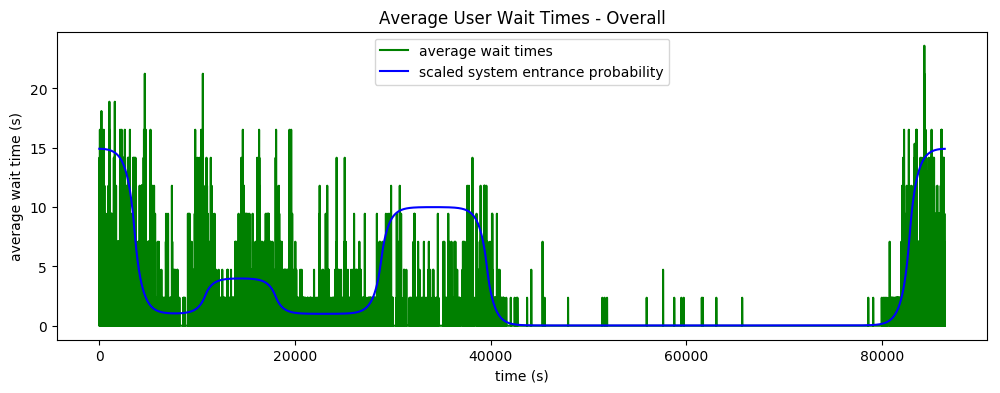

In [3]:
# Plots average wait time per person over all elevators over entire day
# Overlays this data with probability of system entrance for comparison

using PyPlot

raw = readcsv("volumes.csv")
smooth_vol = raw[:,1];
T = size(smooth_vol)[1]
N = T

# plot average wait times overall
avg_waits = zeros(6,N)
waits = zeros(6,N)
people = zeros(6,N)
enum = 1

for elevator in elevators
    for i = 1:N
        waits[enum,i] = elevator.wait_data[1,i]
        people[enum,i] = elevator.wait_data[2,i]
        if elevator.wait_data[2,i] == 0
            avg_waits[enum,i] = 0
        else
            avg_waits[enum,i] = 2.36*elevator.wait_data[1,i]/elevator.wait_data[2,i]
        end
    end
    enum = enum + 1
end

avg_waits_overall = zeros(1,N)
enum = 1
for i = 1:N
    if sum(people[:,i]) != 0
        avg_waits_overall[i] = 2.36*sum(waits[:,i])/sum(people[:,i])
    end
end

figure(figsize=(12,4))
plot(avg_waits_overall[1,:],"g-",20*smooth_vol,"b-")
legend(["average wait times", "scaled system entrance probability"], loc="upper center")
title("Average User Wait Times - Overall");
xlabel("time (s)");
ylabel("average wait time (s)");

**Average Wait Time Per Person**

This plot shows the average wait time per person at any given second throughout the 86,400-second day. Overlaid on this data is the function (scaled up by 20 for visualization) that defines the relative probability over time that a user enters the elevator system.
It is logical that in general, the average wait time in each second follows the distribution of probability of people approaching the elevator system in each second, because as the volume of users increases, people must wait longer to be delivered to their destination. The one exception to the adherence of the average wait time to the usage volume occurs during the usage peak from 28,800s to 39,600s, which represents 4pm - 7pm, the rush to leave WIMR at the end of the day. The deviation of wait time from volume in this region is due to the fact that, while at other peak usage times users are highly likely to have different destinations and a common *origin* (floor 1), in the time period during which everyone is leaving WIMR (4pm - 7pm), they are highly likely to have a different origins and a common *destination*. Because our model assumes that users teleport into their elevators and only their destination matters, the wait times are typically low when users frequently travel to floor 1, since an elevator can simply sit at floor 1 and receive users, producing a wait time of 1 second for each of these users.
As we discussed, the absolute wait times described in this figure are not particularly relevant to the system, although 0 - 24 seconds is a reasonable range for wait times given the implementation of our model and lends confidence that our model is optimal and that our implementation is correct. 

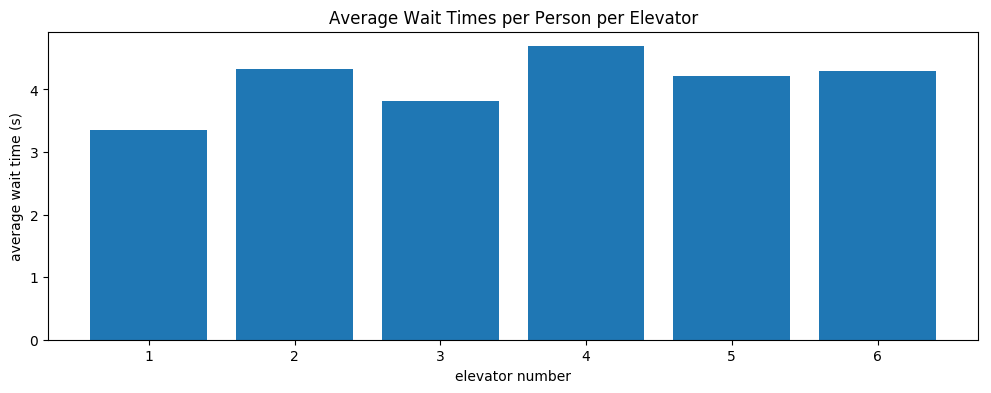

In [4]:
# plot avg wait time across all time within elevators
avg_waits_elevators = zeros(6)
enum = 1
for elevator in elevators
    avg_waits_elevators[enum] = 2.36*sum(elevator.wait_data[1,:])/sum(elevator.wait_data[2,:])
    enum = enum + 1
end

figure(figsize=(12,4))
bar(1:6,avg_waits_elevators);   
title("Average Wait Times per Person per Elevator");
xlabel("elevator number");
ylabel("average wait time (s)");

**Average Wait Time Per Elevator**

Next, we wanted to see if the elevators were being relatively homogeneously utilized. We can see from this plot that the average wait times across each elevator is similar. This suggests that the model is finding optimal solutions because it is utilizing all elevators in the system approximately equally, and thus fully and efficiently utilizing its resources. It is important note that this plot will be slightly different on any given run of the model, because the algorithm randomly selects an elevator to begin with when checking for the optimum among the elevators. This is important when equal costs will be incurred by adding the new user to multiple different elevators, and will hopefully normalize which elevator is ultimately chosen in these cases

The one potentially interesting aspect of this plot is that elevator 1 seems to be slightly under-utilized. This could be due to the multiple aspects of randomness in this model, because the dataset is first being generated randomly and then the search seed for finding the optimal elevator is also random. The other possibile cause of this is the fact that because our system only accounts for users' destinations, in some cases, an elevator can get "stuck" on a floor because that floor is being repeatedly selected as a destination by users. This scenario would drastically reduce the average wait time on this elevator, because if the elevator is waiting on this floor for an extended period of time, the average wait time among all users that enter that destination will be 1 second.

To further ensure that Elevator 1 is behaving as expected compared to relative capacity over time, we have reproduced the average wait time plot for just Elevator 1 below.

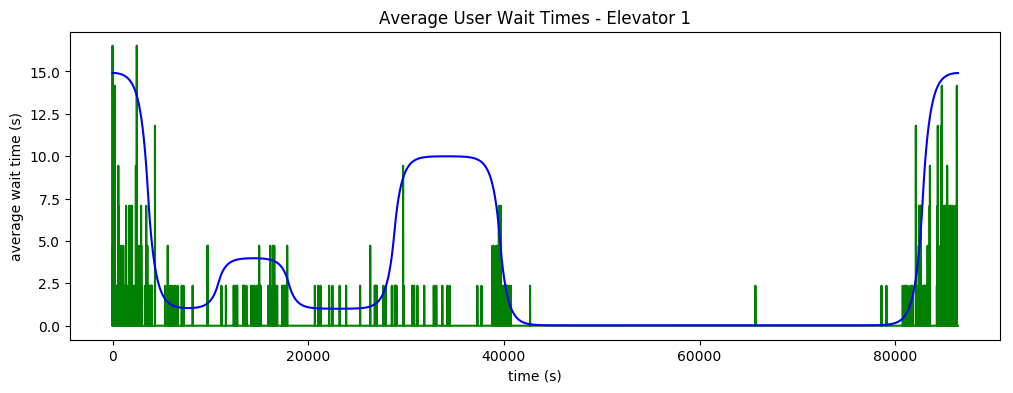

In [5]:
# plots average wait time per person in just elevator 1 over all t
figure(figsize=(12,4))
plot(avg_waits[1,:],"g-",20*smooth_vol,"b-")
title("Average User Wait Times - Elevator 1");
xlabel("time (s)");
ylabel("average wait time (s)");

**Average User Wait Times - Elevator 1**

This plot shows the average user wait times over time for only Elevator 1. As shown, user wait times on Elevator 1 follow the same trend as the overall system, indicating that Elevator 1 is probably being utilized appropriately, and the slightly lower average wait time of users on Elevator 1 is just due to randomness in the data.

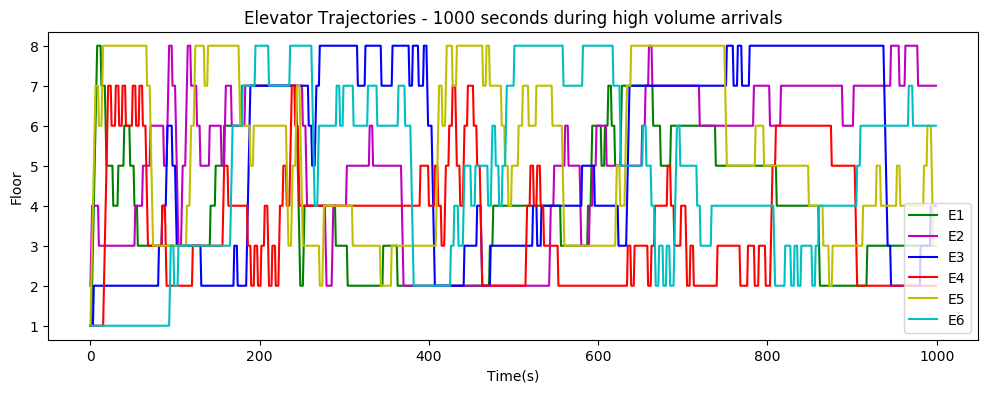

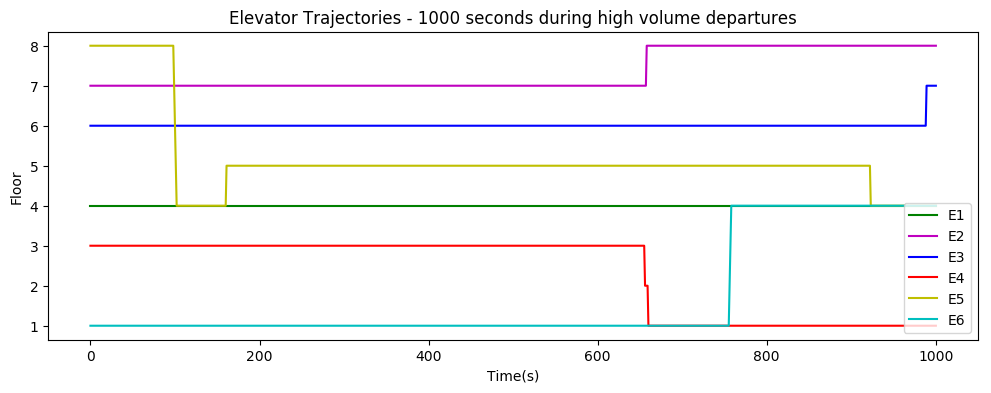

In [6]:
# plots elevator trajectories
e1_traj = e1.floor_data[1:1000]
e2_traj = e2.floor_data[1:1000]
e3_traj = e3.floor_data[1:1000]
e4_traj = e4.floor_data[1:1000]
e5_traj = e5.floor_data[1:1000]
e6_traj = e6.floor_data[1:1000]

figure(figsize=(12,4))
plot(e1_traj,"g-",e2_traj,"m-",e3_traj,"b-",e4_traj,"r-",e5_traj,"y-",e6_traj,"c-");
legend(["E1", "E2","E3","E4", "E5","E6"], loc="lower right");
title("Elevator Trajectories - 1000 seconds during high volume arrivals");
xlabel("Time(s)");
ylabel("Floor");

e1_traj_2 = e1.floor_data[34500:35500]
e2_traj_2 = e2.floor_data[34500:35500]
e3_traj_2 = e3.floor_data[34500:35500]
e4_traj_2 = e4.floor_data[34500:35500]
e5_traj_2 = e5.floor_data[34500:35500]
e6_traj_2 = e6.floor_data[34500:35500]

figure(figsize=(12,4))
plot(e1_traj_2,"g-",e2_traj_2,"m-",e3_traj_2,"b-",e4_traj_2,"r-",e5_traj_2,"y-",e6_traj_2,"c-");
legend(["E1", "E2","E3","E4", "E5","E6"], loc="lower right");
title("Elevator Trajectories - 1000 seconds during high volume departures");
xlabel("Time(s)");
ylabel("Floor");

**Elevator Trajectories**

We could not plot elevator trajectories over all 86,400 seconds because the plot would be exceptionally difficult to interpret due to the density of lines. Therefore, we selected two representative portions of the plot to gain insight into the elevator paths being selected by the algorithm. 

The first plot represents the elevator trajectories over the first 1000 seconds. This timespan represents a 1000-second interval starting at 8am, and occurs during the rush of people coming to work. As described in Appendix A, during this timespan (the 1000 seconds following 8am), users enter the system at a high frequency and most commonly have an origin of floor 1 but rarely have a destination of floor 1. In this plot, we can see that, as expected, all elevators are being utilized in similar ways over time and almost entirely fluctuate between floors 2 and 8, rarely visiting floor 1. On this timescale, it is possible to view and interpret specific decision points, and try to understand why which elevator was selected to travel to which destination at any given time. Unfortunately, this type of analysis is not the most informative, as the plot does not incorporate data on the number of people currently in the elevator at a given time.

The second plot represents a 1000-second time interval within the period of the day that people are generally leaving to go home (4pm - 7pm). This is a period of interest because, although the elevators are handling a high volume of users, we would expect to see generally low wait times and very little elevator activity, and this is exactly what we see. The low activity of elevators over this time period is to be expected, because when the destinations of users are consistently 1 (as they are when everyone is leaving), the system optimizes user wait time by simply holding one elevator (in this case, Elevator 5) at floor 1 and assigning all users to this elevator, thereby making their wait time as low as possible--1 second. This solution is, of course, unrealistic, and an issue that arises because our model does not account for users' widely varied origins in this time period.

# 5. Conclusion<a class="anchor" id="conclusion"></a>
At the outset of this project, we sought to develop a model that would select an elevator trajectory to minimize the total wait time of patrons in a destination-entry elevator system. The ideal model would have accounted for each person's wait time to board, their origin, and their destination.
In the previous sections, we formulated and implemented a model that solves a similar but simplified problem: to minimize total wait time, except without accounting for the time a patron waits for their elevator to arrive, nor the fact that the elevator must consider in its trajectories the origins of users as well as their destinations. In the upcoming discussion, we will present our progress thus far toward full model implementation and discuss other potentially useful additions that could be made to the completed model.

### Full Model Formulation<a class="anchor" id="5A"></a>
The logical next step in this project is the design and implementation of a model that accounts for wait time until elevator arrival as well as user origin *and* destination. We will now discuss some elements of a mathematical model that represents a potiental solution to the full problem. 

In order to incorporate people with various origins, destinations, and wait times until boarding, we first added to and modified our parameters from the previous iteration to include more dimensions. These modified parameters allow us to account for origins and pick-up times in addition to destinations and dropoff times.

**Parameters:**
$$D_{i,j}\,\,=\,distance\,traveled\,on\,the\,trip\,i \to j$$
$$P_{o,d}\,\,=\,number\,of\,people\,with\,origin\,o\,and\,destination\,d$$
$$W_{o,d,m}\,\,=\,time\,person\,m\,with\,origin\,o\,entered\,their\,destination\,d\,where\,m\,=\,1...z$$

After updating our parameters, we updated our decision variables in a similar manner. *X*, the variable representing the path *i > j* taken at time t, remained unchanged. *U*, which previously represented whether the group with destination d was present on a trip *i > j* at time *t*, was updated to include a dimension storing origin as well, so now it tracks the position of users grouped by common origin *and* destination, instead of just destination. Finally, the cost matrix *C* was previously defined as the cost of dropping off the group of people traveling to destination *d* at time *t* -- now, it is the cost of picking up/dropping off the group of people traveling from origin *o* to destination *d* at respective times t1, t2. These variables are formally defined below.

**Decision Variables:**
$$X_{i,j,t}\,\,=\,binary\,variable\,representing\,whether\,the\,path\,from\,i\,\to\,j\,is\,taken\,at\,time\,t$$
$$U_{i,j,t,o,d}\,\,=\,binary\,variable\,representing\,whether\,the\,group\,with\,origin\,o\,and\,destination\,d\,is\,present\,on\,the\,trip\,from\,i \to j\,at\,time\,t$$
$$C_{o,d,t_{1},t_{2}}\,\,=\,the\,cost\,of\,transporting\,the\,number\,of\,people\,who\,must\,go\,from\,floor\,o \to d \,if\,they\,are\,picked\,up\,at\,time\,t_{1}\,and\,arrive\,at\,time\,t_{2}$$

**Objective Function:**
Using these decision variables, we can represent an objective function that is analogous to the original objective function:

$$Minimize\,\,\,\,\,\,\,\,\sum_{i_{1}=1}^{n}\sum_{i_{2}=1}^{n}\sum_{o=1}^{n}\sum_{d=1}^{n}\sum_{t_{1} = 1}^{n}\sum_{t_{2} = 1}^{n}C_{o,d,t_{1},t_{2}}*X_{i_{1},o,t_{1}}*X_{i_{2},d,t_{2}}$$

In words, this objective minimizes the sum of the costs of taking people at origin o to destination d from time t1 to time t2 provided that the elevator visits o (from any state i1) at time t1 and d (from any state i2) at time t2 for all possible origins and all destinations and all possible times t1,t2.

**Constraints - Discussion**
The logical next step in the formulation of this model is the implementation of updated constraints. Many of these implementations are straightforward and follow logically from the previous model. There are, however, a few additional complicating factors introduced by this new dimensionality.

First, with origins incorporated into the elevator trajectory, it may be necessary for an elevator to plan to visit a floor *more than once* in its optimal trajectory. This complication introduces challenges in handling subtours, especially because we cannot even assume that the elevator will visit all states once before returning to a duplicate state. We believe that in this case, the number of steps in a trajectory to visit n distinct states is at minimum, n and at maximum, 2n, but this should be validated with more rigorous analysis.  

Second, the incorporation of origins requires that a person's origin be visited before their destination. This constraint would not be terribly complex to implement; it would be a matter of simply applying a further constraint to the *U* matrix. 

Finally, the model must account for the wait times of each *individual person* incurred as they wait for their elevator to arrive. This is complicated to incorporate specifically because previously, the model relied on the grouping of people by common origin and destination.

We would implement this by adding an additional term to the cost matrix *C* to represent the wait time outside the elevator of all people with origin *o*. 

$$\sum_{m = 1}^{z}\sum_{i = 1}^{n}X(i,o,t_{1})*(t_{1} - W_{o,d,m})$$. 

In words, this term represents the sum of all wait times before elevator arrival of people *m* with origin *o* and destination *d* in the case that the elevator arrives at their origin to pick them up at time t1. With this added term, *C*, the cost of transporting the number of people who must go from floor *o* to floor *d* if they are picked up at time t1 and dropped off at time t2 is now constrained to be:

$$C_{o,d,t_{1},t_{2}} = \sum_{m = 1}^{z}\sum_{i = 1}^{n}X(i,o,t_{1})*(t_{1} - W_{o,d,m}) + P_{o,d}*6.7*(t_{2} - t_{1}) + P_{o,d}*2.36*\sum_{i=1}^{n}\sum_{j=1}^{n}\sum_{k=t_{1}}^{t_{2}}D_{i,j}*U_{i,j,k,o,d}\,\,\,\,\,\,\,o,d = 1,2,3,...,n;\,\,\,1 \leq t1 < t2 \leq n$$

The constraints that have been discussed thus far by no means represent the full model; as discussed, there are many more complications that must be addressed in order to adapt our original model to solve the full problem.

### Modeling the Tradeoff Between Wait Time and Energy Usage<a class="anchor" id="5B"></a>
With a fully-implemented model in place, it would then be useful to optimize elevator trajectory considering not only the minimization of wait time, but the tradeoff of minimizing wait time and energy usage. While in many cases these variables do not necessarily represent a strict tradeoff, one can easily imagine cases when these variables *could* represent a tradeoff. For example, say there was a patron on floor 8 that wanted to go to floor 1. Suppose there is a completely empty elevator waiting on floor 1 that could get to the 8th floor with no stops in 2.36 s/floor * 7 floors = 16.52 seconds, and an elevator that is already headed up to floor 7 but would take 36.62 seconds reach the 8th floor because it must make 3 stops on its way up. Were we only minimizing wait time, the free elevator on floor 1 would be the optimal choice; however, selecting elevator 1 would represent a substantially greater expenditure of energy than would be used if the elevator already going to floor 7 were used.

# Appendix A: Usage Data Generation<a class="anchor" id="appendixA"></a>
***WARNING: The code in this section takes an hour or so to run.***

Because we could not access actual data on the usage of the WIMR elevators, we have used our own collective observations (we have both worked at WIMR for multiple years) to generate dummy data on elevator usage. This dataset simply consists of a time-stamped list of origins and destinations for a single weekday, which we are assuming roughly reflects the elevator usage patterns on any given weekday. It is important to note that the sole entrance to the building as well as the cafeteria is on the first floor.

To generate this data, we separated the day into six distinct time segments: 

    1)	7am – 9am (people arriving at work)
    2)	9am – 11am (people at work)
    3)	11am – 12pm (people going to lunch)
    4)	12pm – 1pm (people returning from lunch)
    5)	1pm – 4pm (people at work)
    6)	4pm – 7pm (people leaving work)
    7)	7pm – 7am (overnight)

The usage over time is defined as the probability in any given second that someone will enter a destination (we assume that the machine processes at most one request each second). We have modeled the probability that in a given second (t) a person will enter a destination with the piecewise function given in column 1 of the table. The probability of a user inputting a specific destination (D) from a specific origin (O) is defined by a series of discrete probability distributions as defined in columns 2 and 3 of the table. Note that all floors are treated equally except floor 1, because the first floor holds both the only entrance and the cafeteria. The listed probabilities only contain the probability that an entered origin origin and destination are 1 -- we divide the remaining probability between floors 2...8 equally.

| Interval | Est. Usage Rate | Origin Distribution  | Destination Distribution |
| -------- |:---------------:| --------------------:| ------------------------:|
| 1        | 3/4             | P(O = 1) = 0.95      | P(D = 1) = 0.05          |
| 2        | 1/20            | P(O = 1) = 0.50      | P(D = 1) = 0.50          |
| 3        | 1/5             | P(O = 1) = 0.25      | P(D = 1) = 0.75          |
| 4        | 1/5             | P(O = 1) = 0.75      | P(D = 1) = 0.25          |
| 5        | 1/20            | P(O = 1) = 0.50      | P(D = 1) = 0.50          |
| 6        | 1/2             | P(O = 1) = 0.05      | P(D = 1) = 0.95          |
| 7        | 1/900           | P(O = 1) = 0.125     | P(D = 1) = 0.125         |


### Generate Smoothed Functions
Because probabilities don't actually change discretely, to make the system more realistic we smoothed these piecewise functions with 2-norm regularization. When we generate the data, we then used the values of these smoothed functions at each second t as the probabilities of outcomes in the dummy dataset.

#### STEP 1: Generate Probability Inputs

In [ ]:
count = Array(range(1,86400))

arrivals = zeros(Float64, 86400, 2)
arrivals[:,1] = count

origin = zeros(Float64, 86400, 2)
origin[:,1] = count

destination = zeros(Float64, 86400, 2)
destination[:,1] = count

input = 1

# 8:00:00 AM - 8:59:59 am
for j = 1:3600
    arrivals[input,2] = .75
    origin[input,2] = .95  
    destination[input,2] = .05
    input = input + 1
end

# 9:00:00 am - 10:59:59 am
for j = 1:7200
    arrivals[input,2] = .05
    origin[input,2] = .5
    destination[input,2] = .5
    input = input + 1
end

# 11:00:00 am - 11:59:59 am
for j = 1:3600
    arrivals[input,2] = .2
    origin[input,2] = .25
    destination[input,2] = .75
    input = input + 1
end

# 12:00:00 am - 12:59:59 pm
for j = 1:3600
    arrivals[input,2] = .2
    origin[input,2] = .75  
    destination[input,2] = .25
    input = input + 1
end

# 1:00:00 pm - 3:59:59 pm
for j = 1:10800
    arrivals[input,2] = .05
    origin[input,2] = .5  
    destination[input,2] = .5
    input = input + 1
end

# 4:00:00 pm - 6:59:59 pm
for j = 1:10800
    arrivals[input,2] = .5
    origin[input,2] = .05  
    destination[input,2] = .95
    input = input + 1
end

# 7:00:00 pm - 6:59:59 am
for j = 1:43200
    arrivals[input,2] = .00111
    origin[input,2] = .125  
    destination[input,2] = .125
    input = input + 1
end

# 7:00:00 AM - 7:59:59 am
for j = 1:3600
    arrivals[input,2] = .75
    origin[input,2] = .95  
    destination[input,2] = .05
    input = input + 1
end

#### STEP 2: Assemble Data and Set Parameters

In [ ]:
nums = count;          # time point
vol = arrivals[:,2];   # volume over time
o1 = origin[:,2];      # probability that origin is 1
d1 = destination[:,2]; # probability that destination is 1

T = size(vol)[1]    # total # of timepoints (should be 24 x 60 x 60 = 86,400)

#### STEP 3: Regularize and Plot Piecewise Probability Functions

In [ ]:
# Uses piecewise function describing probability of a person entering the system at a given time
# Regularizes pieceswise function over t = 1:86,400 seconds 
# Produces plot of original piecewise function overlaid with smoothed function 
# Reads output into CSV file

using JuMP,Gurobi,PyPlot

λ = 500000          # regularization coefficient

m_vol = Model(solver=GurobiSolver(OutputFlag=0))

@variable(m_vol, opt_vol[1:T])
@objective(m_vol, Min, sum((vol[i]-opt_vol[i])^2 for i in 1:T) + λ*sum((opt_vol[i]-opt_vol[i-1])^2 for i = 2:T))
solve(m_vol)
smooth_vol = getvalue(opt_vol)
                        
figure(figsize=(12,4));
plot(nums,vol,"g-",nums,smooth_vol,"b-");
legend(["original", "smoothed"], loc="upper center");
title("Probability of System Entrance at Time t");
xlabel("time (s)");
ylabel("probability of system entrance");
                    
## put values into text file
f = open("volumes.csv","w")
for t = 1:T
    entry = smooth_vol[t];
    write(f,"$entry","\n");
end
close(f)

In [ ]:
# Uses piecewise function describing probability of a person entering floor 1 as their origin over time
# Regularizes pieceswise function over t = 1:86,400 seconds 
# Produces plot of original piecewise function overlaid with smoothed functions describing
# probabilities of a user entering a given origin at a given time

m_o1 = Model(solver=GurobiSolver(OutputFlag=0))

λ = 250000          # regularization coefficient

@variable(m_o1, opt_o1[1:T])
@objective(m_o1, Min, sum((o1[i]-opt_o1[i])^2 for i in 1:T) + λ*sum((opt_o1[i]-opt_o1[i-1])^2 for i = 2:T))
solve(m_o1)
smooth_o1 = getvalue(opt_o1)

smooth_o28 = zeros(T)                                        
for i = 1:T
    smooth_o28[i] = (1-smooth_o1[i])/7   # computes probability of origin being any given floor besides 1
end

figure(figsize=(12,4));
plot(o1,"g-",smooth_o1,"b-",smooth_o28,"r-");
legend(["original P(O = 1)", "smoothed P(O = 1)","smoothed P(O = 2,...,8)"], loc="upper center");
title("Probability of given Origin (O) at Time t");
xlabel("time (s)");
ylabel("probability of given origin");

In [ ]:
# Uses piecewise function describing probability of a person entering floor 1 as their destination over time
# Regularizes pieceswise function over t = 1:86,400 seconds 
# Produces plot of original piecewise function overlaid with smoothed functions describing
# probabilities of a user entering a given destination at a given time

m_d1 = Model(solver=GurobiSolver(OutputFlag=0))

λ = 250000          # regularization coefficient

@variable(m_d1, opt_d1[1:T])
@objective(m_d1, Min, sum((d1[i]-opt_d1[i])^2 for i in 1:T) + λ*sum((opt_d1[i]-opt_d1[i-1])^2 for i = 2:T))
solve(m_d1)
smooth_d1 = getvalue(opt_d1)

smooth_d28 = zeros(T)                                        
for i = 1:T
    smooth_d28[i] = (1-smooth_d1[i])/7   # computes probability of origin being any given floor besides 1
end

figure(figsize=(12,4));
plot(d1,"g-",smooth_d1,"b-",smooth_d28,"r-");
legend(["original P(D = 1)", "smoothed P(D = 1)","smoothed P(D = 2,...,8)"], loc="upper right");
title("Probability of given destination at Time t");
xlabel("time (s)");
ylabel("probability of given destination");

In [ ]:
## put origin / destination probability values into csv file
f = open("orig_dests.csv","w")
for t = 1:T
    orig_prob = smooth_o1[t];
    dest_prob = smooth_d1[t]
    write(f,"$orig_prob",",","$dest_prob","\n");
end
close(f)

#### STEP 4: Generate Dummy Data Using Regularized Probability Functions
Using the values of the smoothed functions above, we then generated a dummy dataset. This dataset includes two columns, the first representing the origin floor and the second representing the destination second. Each row represents a given second of a 24-hour day. (0,0) values represent seconds in which no one entered a destination into the system. 

In [ ]:
# For each second in time:
# 1) pulls value of smoothed function at time t describing probability that a user will enter the elevator system
# 2) generates a 1 with this probability, and a 0 otherwise, representing whether a user came to the system at that second
# 3) if a user did come, pulls values of smoothed functions at time t describing probability that a user will
#    enter origin o, destination d
# 4) using these probabilties, randomly generates an origin and destination accordingly
# 5) writes these values to a csv file. This is the csv that is put into the simulation.

using Distributions

# column 1 is origin data, column 2 is destination data
dummy_data = zeros(T,2) 

# generates 1 or 0 - represents whether user enters elevator system
function rand1(vol)
    input = 0               
    r = rand(Uniform(0,1))
    if r <= vol
        input = 1
    end
    return input
end

# generates origin and destination of user
function rand2(o1,d1)
    o28 = (1 - o1)/7
    orig = 0
    r = rand(Uniform(0,1))
    if r < o1
        orig = 1
    end
    for i = 1:7
        if r >= o1 + (i-1)*o28 && r < o1 + i*o28
            orig = i+1
        end
    end
     
    d28 = (1 - d1)/7
    dest = 0
    r = rand(Uniform(0,1))
    if r < d1
        dest = 1
    end
    for i = 1:7
        if r >= d1 + (i-1)*d28 && r < d1 + i*d28
            dest = i+1
        end
    end
    return orig,dest
end

# writes to CSV file
f = open("dummydata.csv","w")
for t = 1:T
    r = rand1(smooth_vol[t]) # determine whether someone entered a destination at second t
    if r == 1
        orig,dest = rand2(smooth_o1[t],smooth_d1[t])
        while orig == dest
            orig,dest = rand2(smooth_o1[t],smooth_d1[t])
        end
        write(f,"$orig",",","$dest","\n");
    else
        write(f,"0",",","0","\n")
    end
end
close(f)

# Appendix B: WIMR Elevators - Physical Parameters Data<a class="anchor" id="appendixB"></a>

Below is the data collected on timing parameters associated with the WIMR elevators. Bolded values in the bottom row represent the means.


|Time between Floors (s) |  Load (s)   | 
|-----------------------:|------------:| 
| 2.29                   | 6.9         | 
| 2.22                   | 6.4         |  
| 2.43                   | 6.5         | 
| 2.36                   | 6.8         | 
| 2.29                   | 7.2         | 
| 2.43                   | 6.8         | 
| 2.43                   | 6.5         | 
| 2.36                   | 7.0         | 
| 2.36                   | 6.4         | 
| 2.43                   | 6.6         | 
|**2.36**                |**6.7**      |
